In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [9]:
image = cv2.imread('Jockey/img00001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
masks = mask_generator.generate(image)

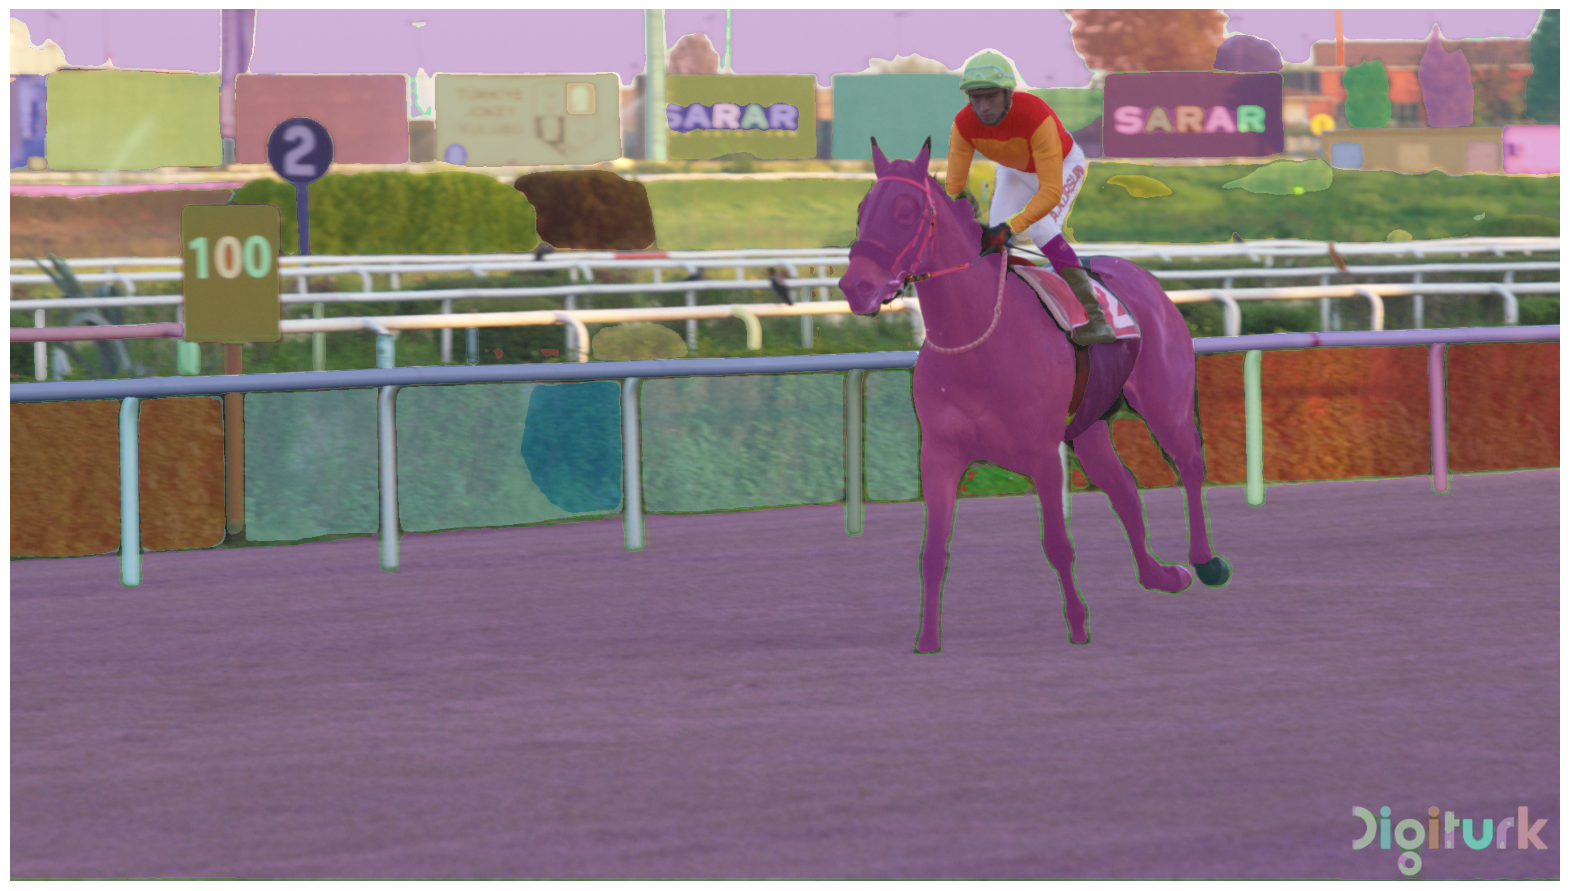

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bboxes_on_image(image, segmentation_dicts):
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for seg_dict in segmentation_dicts:
        bbox = seg_dict['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

In [6]:
# draw_bboxes_on_image(image, masks)

In [14]:
def create_instance_ids_map(segmentation_dicts, image_shape):
    instance_ids_map = np.zeros(image_shape, dtype=np.uint16)
    instance_id = 1

    for seg_dict in segmentation_dicts:
        seg_mask = seg_dict['segmentation']
        bbox = seg_dict['bbox']

        # Ensure bbox is within the valid range of image_shape
        bbox[0] = max(0, min(bbox[0], image_shape[1]))
        bbox[1] = max(0, min(bbox[1], image_shape[0]))
        bbox[2] = max(0, min(bbox[2], image_shape[1]))
        bbox[3] = max(0, min(bbox[3], image_shape[0]))

        # print('bbox:', bbox)
        # print('seg map:', seg_mask)
        # Assign unique instance ID to each pixel within the bounding box
        # mask_updated = seg_mask * instance_id
        # print(mask_updated)
        # Assign unique instance ID to each pixel within the bounding box
        # Resize seg_mask to match the dimensions of the bounding box region
        seg_mask_resized = seg_mask[bbox[1]:bbox[3], bbox[0]:bbox[2]].astype(np.uint16)
        
        # Assign unique instance ID to each pixel within the bounding box
        instance_ids_map[bbox[1]:bbox[3], bbox[0]:bbox[2]] += seg_mask_resized * instance_id


        # Increment instance ID for the next object
        instance_id += 1
        # print('id :', instance_id)

    return instance_ids_map

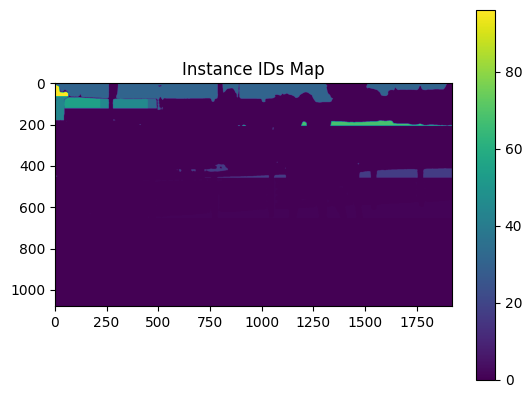

In [15]:
def show_instance_map(instance_ids_map):
    plt.imshow(instance_ids_map, cmap='viridis')
    plt.colorbar()
    plt.title('Instance IDs Map')
    plt.show()

# Example usage:
image_shape = (1080, 1920)  # Example image shape
instance_ids_map = create_instance_ids_map(masks, image_shape)
show_instance_map(instance_ids_map)


In [39]:
import imageio

def load_cityscapes_image(image_path):
    return imageio.imread(image_path)

# Example usage:
color_image_path = 'berlin_000542_000019_gtFine_color.png'
instance_ids_image_path = 'berlin_000542_000019_gtFine_instanceIds.png'
label_ids_image_path = 'berlin_000542_000019_gtFine_labelIds.png'

color_image = load_cityscapes_image(color_image_path)
instance_ids_image = load_cityscapes_image(instance_ids_image_path)
label_ids_image = load_cityscapes_image(label_ids_image_path)

/tmp/ipykernel_1222787/265506490.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(image_path)
/home/maryamsana_98/.local/lib/python3.8/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


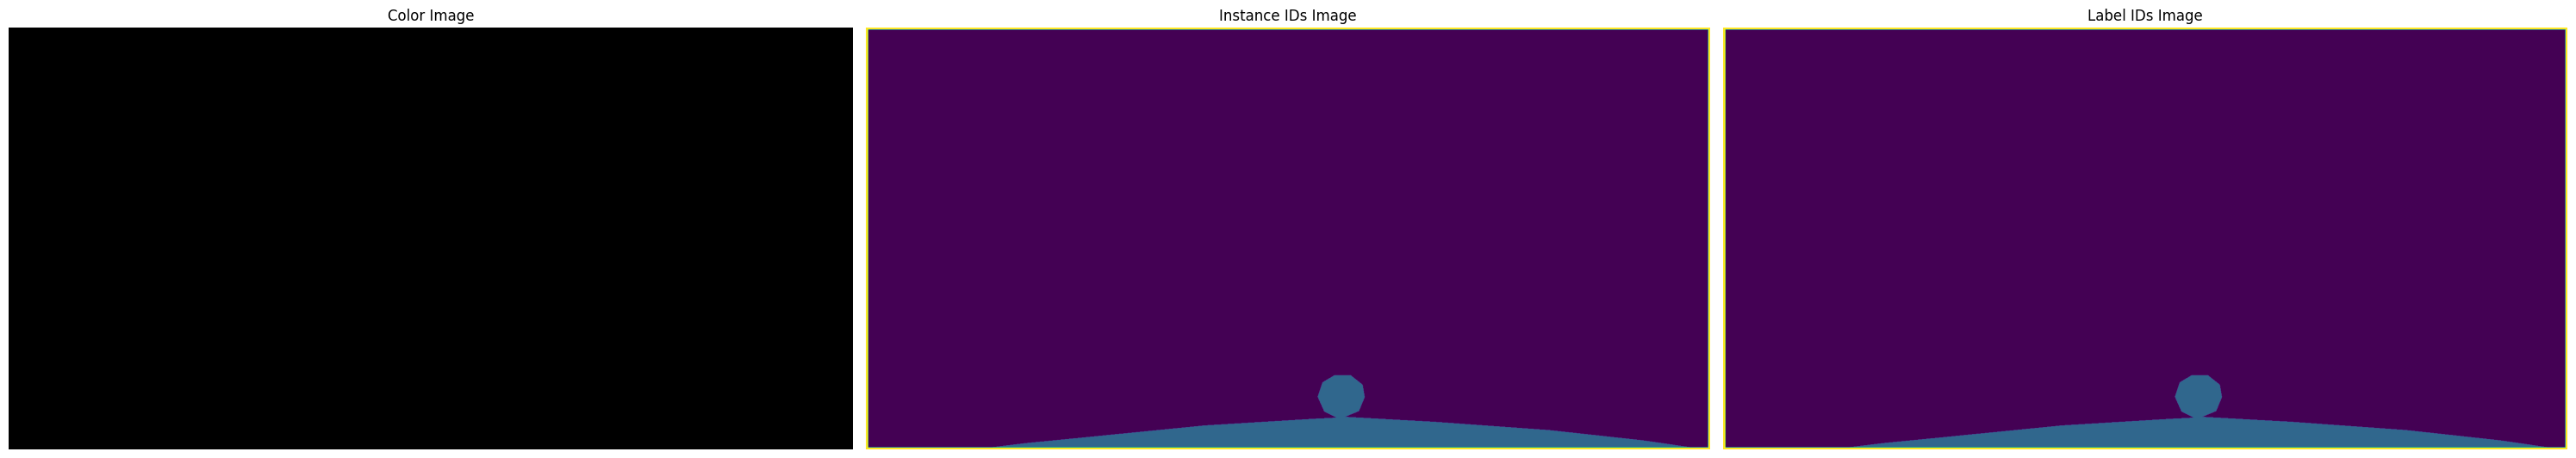

In [45]:
def show_images(images, titles=None):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(10 * num_images, 10))
    
    if titles is None:
        titles = ['Image {}'.format(i+1) for i in range(num_images)]
    
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
show_images([color_image, instance_ids_image, label_ids_image], 
            ['Color Image', 'Instance IDs Image', 'Label IDs Image'])

/tmp/ipykernel_1224089/2032025773.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_instances)


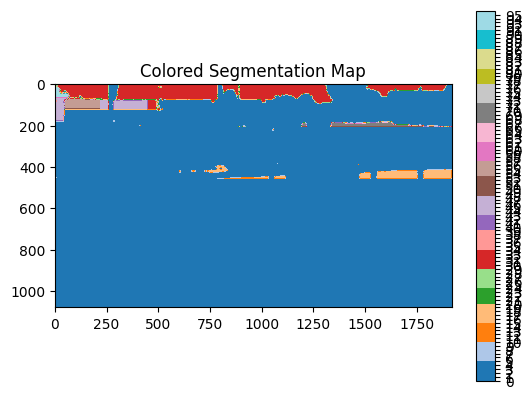

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def create_colored_segmentation_map(segmentation_dicts):
    instance_ids_map = create_instance_ids_map(segmentation_dicts, (1080, 1920) )
    num_instances = np.max(instance_ids_map)
    
    # Generate a colormap with a unique color for each instance ID
    colors = plt.cm.get_cmap('tab20', num_instances)
    colormap = ListedColormap([colors(i) for i in range(num_instances)])
    
    # Create the colored segmentation map
    plt.imshow(instance_ids_map, cmap=colormap)
    plt.colorbar(ticks=np.arange(0, num_instances))
    plt.title('Colored Segmentation Map')
    plt.show()


create_colored_segmentation_map(masks)
